In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "8g")\
    .getOrCreate()

spark

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit

from common import *

pd.set_option('display.max_rows', 100)

In [3]:
PREFIX = "main/ycsb-backup/ycsb-test-clients-10000"

client_sdf = spark.read.csv(f"{PREFIX}/*/client/0/metadata.csv", header=True)\
    .withColumn(
        "prefix",
        ancestor_udf(F.input_file_name(), lit(3))
    )

server_sdf = spark.read.csv(f"{PREFIX}/*/server/0-0/metadata.csv", header=True)\
    .withColumn(
        "prefix",
        ancestor_udf(F.input_file_name(), lit(3))
    )

index_sdf = server_sdf.join(client_sdf, on='prefix')\
    .withColumn("duration", col("duration").cast(T.IntegerType()))\
    .withColumn("txns", col("txns").cast(T.IntegerType()))\
    .withColumn("clients", col("clients").cast(T.IntegerType()))\
    .withColumn("rate", col("rate").cast(T.IntegerType()))\
    .withColumn("sample", col("sample").cast(T.IntegerType()))

index_sdf.toPandas()

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:mh,...,wl:records,wl:mh_homes,wl:mp,wl:hot_records,wl:mp_parts,wl:hot,wl:writes,wl:value_size,wl:nearest,wl:sp_partition
0,file:///home/ctring/data/slog/main/ycsb-backup...,1.0.873,baseline.conf,30,1000000,100,0,10,basic,50,...,10,2,50,2,2,10000,10,100,1,-1
1,file:///home/ctring/data/slog/main/ycsb-backup...,1.0.873,baseline.conf,30,1000000,125,0,10,basic,50,...,10,2,50,2,2,10000,10,100,1,-1
2,file:///home/ctring/data/slog/main/ycsb-backup...,1.0.873,baseline.conf,30,1000000,250,0,10,basic,50,...,10,2,50,2,2,10000,10,100,1,-1
3,file:///home/ctring/data/slog/main/ycsb-backup...,1.0.873,baseline.conf,30,1000000,375,0,10,basic,50,...,10,2,50,2,2,10000,10,100,1,-1
4,file:///home/ctring/data/slog/main/ycsb-backup...,1.0.873,baseline.conf,30,1000000,500,0,10,basic,50,...,10,2,50,2,2,10000,10,100,1,-1
5,file:///home/ctring/data/slog/main/ycsb-backup...,1.0.873,ddr_ts.conf,30,1000000,100,0,10,basic,50,...,10,2,50,2,2,10000,10,100,1,-1
6,file:///home/ctring/data/slog/main/ycsb-backup...,1.0.873,ddr_ts.conf,30,1000000,125,0,10,basic,50,...,10,2,50,2,2,10000,10,100,1,-1
7,file:///home/ctring/data/slog/main/ycsb-backup...,1.0.873,ddr_ts.conf,30,1000000,250,0,10,basic,50,...,10,2,50,2,2,10000,10,100,1,-1
8,file:///home/ctring/data/slog/main/ycsb-backup...,1.0.873,ddr_ts.conf,30,1000000,375,0,10,basic,50,...,10,2,50,2,2,10000,10,100,1,-1
9,file:///home/ctring/data/slog/main/ycsb-backup...,1.0.873,ddr_ts.conf,30,1000000,500,0,10,basic,50,...,10,2,50,2,2,10000,10,100,1,-1


# Throughput

In [4]:
# Extract all prefixes in the index
throughput_df = index_sdf.select("prefix", "sample").toPandas()
# Compute the throughput of each prefix
throughput_df["throughput"] = throughput_df.apply(
    lambda row: throughput(
        spark,
        row["prefix"],
        row["sample"],
        trim_start_sec=0,
        trim_end_sec=0,
        new_version=False,
    ).first().throughput,
    axis=1
)
# Associate metadata from the index to the throughputs
throughput_df = throughput_df.merge(index_sdf.drop("sample").toPandas(), on="prefix")
# Try to cast columns to appropriate types 
throughput_df = throughput_df.convert_dtypes()

throughput_df.sort_values(by="config_name")

,prefix,sample,throughput,version,config_name,duration,txns,clients,rate,wl:name,...,wl:records,wl:mh_homes,wl:mp,wl:hot_records,wl:mp_parts,wl:hot,wl:writes,wl:value_size,wl:nearest,wl:sp_partition
0,file:///home/ctring/data/slog/main/ycsb-backup...,10,9500.533905,1.0.873,baseline.conf,30,1000000,100,0,basic,...,10,2,50,2,2,10000,10,100,1,-1
1,file:///home/ctring/data/slog/main/ycsb-backup...,10,11905.040435,1.0.873,baseline.conf,30,1000000,125,0,basic,...,10,2,50,2,2,10000,10,100,1,-1
2,file:///home/ctring/data/slog/main/ycsb-backup...,10,21395.676969,1.0.873,baseline.conf,30,1000000,250,0,basic,...,10,2,50,2,2,10000,10,100,1,-1
3,file:///home/ctring/data/slog/main/ycsb-backup...,10,27725.604579,1.0.873,baseline.conf,30,1000000,375,0,basic,...,10,2,50,2,2,10000,10,100,1,-1
4,file:///home/ctring/data/slog/main/ycsb-backup...,10,29523.874272,1.0.873,baseline.conf,30,1000000,500,0,basic,...,10,2,50,2,2,10000,10,100,1,-1
5,file:///home/ctring/data/slog/main/ycsb-backup...,10,13218.202682,1.0.873,ddr_ts.conf,30,1000000,100,0,basic,...,10,2,50,2,2,10000,10,100,1,-1
6,file:///home/ctring/data/slog/main/ycsb-backup...,10,17294.221239,1.0.873,ddr_ts.conf,30,1000000,125,0,basic,...,10,2,50,2,2,10000,10,100,1,-1
7,file:///home/ctring/data/slog/main/ycsb-backup...,10,29177.829184,1.0.873,ddr_ts.conf,30,1000000,250,0,basic,...,10,2,50,2,2,10000,10,100,1,-1
8,file:///home/ctring/data/slog/main/ycsb-backup...,10,29011.08683,1.0.873,ddr_ts.conf,30,1000000,375,0,basic,...,10,2,50,2,2,10000,10,100,1,-1
9,file:///home/ctring/data/slog/main/ycsb-backup...,10,31757.999825,1.0.873,ddr_ts.conf,30,1000000,500,0,basic,...,10,2,50,2,2,10000,10,100,1,-1


<AxesSubplot:xlabel='clients'>

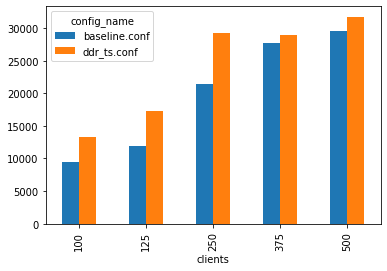

In [5]:
remove_constant_columns(throughput_df, ["config_name", "throughput"])
pivot_values = "throughput"
pivot_columns = "config_name"
pivot_index = throughput_df.columns.drop([pivot_values, pivot_columns, "prefix"])
pivoted = throughput_df.pivot(index=pivot_index, columns=pivot_columns, values=pivot_values)
pivoted.sort_index().plot.bar()

# Latency

In [6]:
prefixes = list(map(lambda r : r.prefix, index_sdf.select("prefix").collect()))
latency_sdf = latency(spark, prefixes, new_version=False).withColumn("coordinator_region", (col("coordinator") / 3).cast(T.IntegerType()))
latency_sdf = latency_sdf.join(index_sdf, on="prefix").orderBy("clients").cache()
latency_sdf.show()

+--------------------+-------+-----------+--------+----------+----------+------------------+-------+-------------+--------+-------+-------+----+------+-------+-----+----------+----------+-----------+-----+--------------+-----------+------+---------+-------------+----------+---------------+
|              prefix| txn_id|coordinator|replicas|partitions|   latency|coordinator_region|version|  config_name|duration|   txns|clients|rate|sample|wl:name|wl:mh|wl:mh_zipf|wl:records|wl:mh_homes|wl:mp|wl:hot_records|wl:mp_parts|wl:hot|wl:writes|wl:value_size|wl:nearest|wl:sp_partition|
+--------------------+-------+-----------+--------+----------+----------+------------------+-------+-------------+--------+-------+-------+----+------+-------+-----+----------+----------+-----------+-----+--------------+-----------+------+---------+-------------+----------+---------------+
|file:///home/ctri...|1658403|          3|     [1]|       [0]|  2.900224|                 1|1.0.873|baseline.conf|      30|1000

In [7]:
def plot_latency_per_region(sdf_dict):
    rows = 2
    cols = 4
    _, ax = plt.subplots(rows, cols, figsize=(15, 7))

    for i in range(8):
        r, c = i // cols, i % cols
        
        for label, sdf in sdf_dict.items():
            plot_cdf(
                ax[r, c],
                collect_col(sdf.where(col("coordinator_region") == i), "latency"),
                label=label,
                linewidth=0,
                marker='o'
            )

        ax[r, c].set_title(f"region = {i}")
        ax[r, c].set_xlabel("latency (ms)")
        ax[r, c].legend()

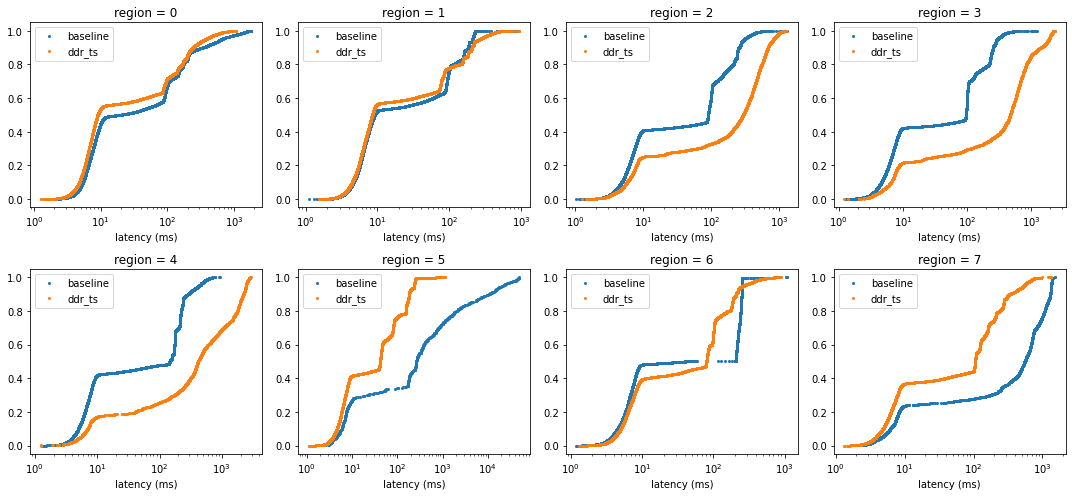

In [14]:
extra_filter = col("clients") == 500
baseline_sdf = latency_sdf.where((col("config_name") == "baseline.conf") & extra_filter).cache()
ddr_ts_sdf = latency_sdf.where((col("config_name") == "ddr_ts.conf") & extra_filter).cache()
plot_latency_per_region({
    "baseline": baseline_sdf,
    "ddr_ts": ddr_ts_sdf
})
plt.tight_layout()